### Spatial fidelity testing ###

Testing the fidelity of the DePreSys data to see where and how and why it fails.

In [1]:
# Local imports
import os
import sys
import glob
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

# # Specific imports
# from ncdata.iris_xarray import cubes_to_xarray, cubes_from_xarray

# # Load my specific functions
# sys.path.append("/home/users/benhutch/unseen_functions")
# import functions as funcs

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# test_tas_obs_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/obs/ERA5_tas_UK_1960_DJF_day.npy"
# test_tas_model_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/HadGEM3-GC31-MM_tas_UK_1960_DJF_day.npy"

In [3]:
# # loada the data files
# tas_obs = np.load(test_tas_obs_path)
# tas_model = np.load(test_tas_model_path)

In [4]:
%%time

# load in one of the smaller observations datasets
wind_data_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_wind_daily_1952_2020.nc"

# Load the data with iris
wind_data_obs = iris.load_cube(wind_data_path, "si10")

CPU times: user 14.5 s, sys: 136 ms, total: 14.6 s
Wall time: 874 ms


In [5]:
# %%time

sys.path.append("/home/users/benhutch/unseen_functions")
from functions import load_model_data_xarray

# # Set up the members list
# members_list = ['r10i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f2',
#                 'r6i1p1f2', 'r7i1p1f2', 'r8i1p1f2', 'r9i1p1f2']
members_list = ['r1i1p1f2']

# Set up an empty list to store the data
model_ds_list = []

# loop over the members
for m, member_this in tqdm(enumerate(members_list)):
    
    # print member this
    print(member_this)
    
    # Load in the data
    model_ds_this =load_model_data_xarray(
    model_variable="sfcWind",
    model="HadGEM3-GC31-MM",
    experiment="dcppA-hindcast",
    start_year=1960,
    end_year=1960,
    first_fcst_year=1961,
    last_fcst_year=1960 + 10,
    months=[12, 1, 2],
    member=member_this,
    frequency="day",
    parallel=False,
    )

    # Append to the list
    model_ds_list.append(model_ds_this)

# Combine the list by members
model_ds = xr.concat(model_ds_list, dim="member")

0it [00:00, ?it/s]

r1i1p1f2
Model path: /badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast
The model path root is badc
Number of unique variant labels: 10
For model: HadGEM3-GC31-MM
First 10 unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
Number of unique variant labels: 10
Unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
First 10 model files: ['/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/sfcWind/gn/files/d20200417/sfcWind_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19601101-19601230.nc', '/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/sfcWind/gn/files/d20200417/sfcWind_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19610101-19611230.nc', '/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/sfc



Processing init years: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]
1it [00:00,  3.46it/s]


In [6]:
# Turn into an iris cube
model_cube = model_ds["sfcWind"].to_iris()

In [7]:
# Intersection to get on the right grid
model_cube = model_cube.intersection(longitude=(-180, 180))

Now we want to select only the DJF days from both the obs and model data.

In [8]:
# Select months of interest [12, 1, 2]
# form the obs data
# extract between 1960-12-01 and 2019-03-01
wind_data_obs = wind_data_obs.extract(iris.Constraint(time=lambda cell: datetime(1960, 12, 1) <= cell.point <= datetime(2019, 3, 1)))

# exrtract only DJF from this
wind_data_obs = wind_data_obs.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

In [9]:
# # extract the first day of the obs data
# wind_data_obs_first_day = wind_data_obs[0, :, :]

# # extrcat the values
# wind_data_obs_first_day_values = wind_data_obs_first_day.data

In [10]:
# # extract the lats and lons
# lats = wind_data_obs_first_day.coord("latitude").points
# lons = wind_data_obs_first_day.coord("longitude").points

In [11]:
# import cartopy.crs as ccrs

# # Set up the figure
# plt.figure(figsize=(10, 10))

# # Set up theh projection
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Add the coastlines
# ax.coastlines()

# # Plot the data
# plt.contourf(
#     lons,
#     lats,
#     wind_data_obs_first_day_values,
#     transform=ccrs.PlateCarree(),
#     cmap="viridis",
#     levels=20,
#     extend="both",
# )

# # Add the box
# plt.plot(
#     [uk_n_sea_box["lon1"], uk_n_sea_box["lon1"], uk_n_sea_box["lon2"], uk_n_sea_box["lon2"], uk_n_sea_box["lon1"]],
#     [uk_n_sea_box["lat1"], uk_n_sea_box["lat2"], uk_n_sea_box["lat2"], uk_n_sea_box["lat1"], uk_n_sea_box["lat1"]],
#     color="red",
#     transform=ccrs.PlateCarree(),
# )

Now we want to limit both the obs and the model data to the same region before regridding the obs data onto the model grid.

In [12]:
# set up a box
uk_n_sea_box = {
    "lat1": 50,
    "lat2": 60,
    "lon1": -7,
    "lon2": 5,
}

In [13]:
# limit the wind data obs to the north sea box
wind_data_obs_box = wind_data_obs.intersection(
    latitude=(uk_n_sea_box["lat1"], uk_n_sea_box["lat2"]),
    longitude=(uk_n_sea_box["lon1"], uk_n_sea_box["lon2"]),
)

# # limit the model data to the north sea box
model_cube_box = model_cube.intersection(
    latitude=(uk_n_sea_box["lat1"], uk_n_sea_box["lat2"]),
    longitude=(uk_n_sea_box["lon1"], uk_n_sea_box["lon2"]),
)

In [14]:
# regrid the wind data obs to the model data
wind_data_obs_box_rg = wind_data_obs_box.regrid(model_cube_box, iris.analysis.Linear())

In [15]:
# %%time

# # extract the first value of both to check this has worked
# wind_data_obs_box_first_day = wind_data_obs_box[0, :, :]
# model_cube_box_first_day = model_cube_box[0, 0, 0, :, :]

# # Extract the values of both
# wind_data_obs_box_first_day_values = wind_data_obs_box_first_day.data
# model_cube_box_first_day_values = model_cube_box_first_day.data

In [16]:
# # extract the obs lats
# obs_lats = wind_data_obs_box_first_day.coord("latitude").points
# obs_lons = wind_data_obs_box_first_day.coord("longitude").points

# # Extract the model lats and lons
# model_lats = model_cube_box_first_day.coord("latitude").points
# model_lons = model_cube_box_first_day.coord("longitude").points

In [17]:
# # print the time value for wind_data_obs_box_first_day
# print(wind_data_obs_box_first_day.coord("time").points)

In [18]:
# fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the observational data
# im0 = axs[0].imshow(
#     wind_data_obs_box_first_day_values,
#     extent=[obs_lons.min(), obs_lons.max(), obs_lats.min(), obs_lats.max()],
#     transform=ccrs.PlateCarree(),
#     cmap="viridis",
#     origin='upper',
#     aspect='auto'
# )
# axs[0].coastlines()
# # Set up theh projection
# axs[0].set_title("Obs (ERA5, no regrid)")

# # Plot the model data
# im1 = axs[1].imshow(
#     model_cube_box_first_day_values,
#     extent=[model_lons.min(), model_lons.max(), model_lats.min(), model_lats.max()],
#     transform=ccrs.PlateCarree(),
#     cmap="viridis",
#     origin='upper',
#     aspect='auto'
# )
# axs[1].coastlines()
# axs[1].set_title("Model (DePreSys)")

# # Get them to share a horizontal colorbar
# cbar = plt.colorbar(im0, ax=axs, orientation="horizontal", fraction=0.046, pad=0.04)
# cbar.set_label("10m wind speed (m/s)")

# plt.show()

In [19]:
# Now regrid the obs data to the model resolution
wind_data_obs_box_rg = wind_data_obs_box.regrid(model_cube_box, iris.analysis.Linear())

In [20]:
# Now check that the processed data looks okay
# Set up the directories
model_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/"
obs_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/obs/"

# extract the data for 2010
model_arr = np.load(glob.glob(model_dir + "*_2010_*")[0])
obs_arr = np.load(glob.glob(obs_dir + "*_1964_*")[0])

In [21]:
model_arr.shape

(1, 10, 90, 18, 14)

In [ ]:
# # exrtact the lats and lons
# metadata_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/"

# # Load the metadata
# model_lats = np.load(glob.glob(metadata_dir + "*2010*lats*")[0])
# model_lons = np.load(glob.glob(metadata_dir + "*2010*lons*")[0])

In [ ]:
# # extract the first values
# model_arr_first = model_arr[0, 0, 0, :, :]

# # extract the first December 2010 from the obs data
# wind_data_obs_2010 = wind_data_obs_box_rg.extract(iris.Constraint(time=lambda cell: cell.point == datetime(2010, 12, 1)))

In [ ]:
# wind_data_obs_2010_values = wind_data_obs_2010.data

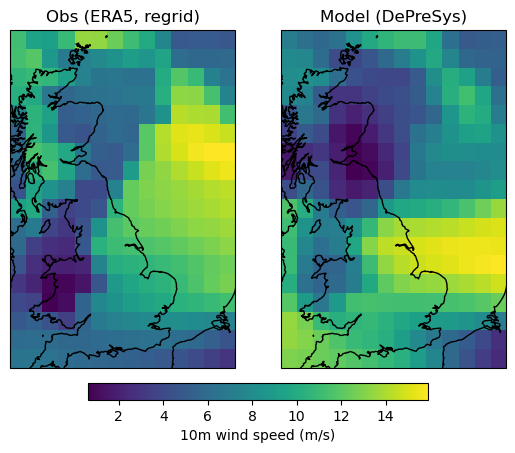

In [ ]:
# import cartopy.crs as ccrs

# fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the observational data
# im0 = axs[0].imshow(
#     wind_data_obs_2010_values,
#     extent=[model_lons.min(), model_lons.max(), model_lats.min(), model_lats.max()],
#     transform=ccrs.PlateCarree(),
#     cmap="viridis",
#     origin='upper',
#     aspect='auto'
# )
# axs[0].coastlines()
# # Set up theh projection
# axs[0].set_title("Obs (ERA5, regrid)")

# # Plot the model data
# im1 = axs[1].imshow(
#     model_arr_first,
#     extent=[model_lons.min(), model_lons.max(), model_lats.min(), model_lats.max()],
#     transform=ccrs.PlateCarree(),
#     cmap="viridis",
#     origin='upper',
#     aspect='auto'
# )
# axs[1].coastlines()
# axs[1].set_title("Model (DePreSys)")

# # Get them to share a horizontal colorbar
# cbar = plt.colorbar(im0, ax=axs, orientation="horizontal", fraction=0.046, pad=0.04)
# cbar.set_label("10m wind speed (m/s)")

# plt.show()

Weird that the obs looks very different, but at least it looks similar to the model data.

In [ ]:
# # extract the members
# model_cube_box_members = model_cube_box.coord("member").points

In [ ]:
# model_cube_box_members

array([1])

In [20]:
# # extract the data
wind_data_obs_box_rg_values = wind_data_obs_box_rg.data
# model_cube_box_values = model_cube_box.data

In [ ]:
# # extract the data
# obs_data_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/obs/ERA5_sfcWind_UK_1960_DJF_day.npy"
# model_data_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/HadGEM3-GC31-MM_sfcWind_UK_1960_DJF_day.npy"

# #load the data
# wind_data_obs_box_rg_values = np.load(obs_data_path)
# model_cube_box_values = np.load(model_data_path)

In [ ]:
# wind_data_obs_box_rg.shape

(5324, 18, 14)

In [ ]:
# model_cube_box.shape

(1, 1, 3750, 18, 14)

In [22]:
# Loop over and extract the data
years_list = np.arange(1960, 2018 + 1)

# Set up an empty array to append to
model_arr_full = np.zeros((len(years_list), 10, 90, model_cube_box.shape[3], model_cube_box.shape[4]))

model_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/"

# Loop over the years
for i, year in enumerate(range(1960, 2018 + 1)):
    
    # extract the data for this year
    model_arr = np.load(glob.glob(model_dir + f"*sfcWind_UK_{year}_*")[0])
    
    # append to the list
    model_arr_full[i, :, :, :, :] = model_arr

In [23]:
model_arr_full.shape

(59, 10, 90, 18, 14)

In [24]:
# extract the unique years from the obs data
obs_times = wind_data_obs_box_rg.coord("time").points

# time:units = "days since 1952-01-01 00:00:00" ;
# time:calendar = "proleptic_gregorian" ;
# convert obs times to datetime
obs_times_dt = pd.to_datetime(obs_times, origin="1952-01-01", unit="D")

# extract the unique years
obs_years = obs_times_dt.year.unique()


In [25]:
len(obs_years)

60

In [26]:
model_cube_box_members = np.shape(model_arr_full)[1]

In [27]:
model_cube_box_members

10

In [28]:
model_arr_full.shape

(59, 10, 90, 18, 14)

In [29]:
# extrcat all of the obs data
wind_data_obs_box_rg_values = wind_data_obs_box_rg.data

In [30]:
wind_data_obs_box_rg_values

masked_array(
  data=[[[13.606068 , 11.564998 ,  9.894495 , ...,  6.653378 ,
           6.7000265,  6.632351 ],
         [14.384009 , 14.451524 , 10.546085 , ...,  6.431648 ,
           6.579074 ,  6.684036 ],
         [14.550165 , 14.779551 , 14.062279 , ...,  9.728365 ,
           7.1609716,  6.3038197],
         ...,
         [ 8.531701 , 10.679288 ,  9.044909 , ..., 13.511608 ,
          13.296914 , 12.664367 ],
         [10.509617 , 10.923256 , 11.491928 , ..., 13.666471 ,
          13.332199 , 12.657473 ],
         [11.787228 , 11.656977 , 11.604417 , ..., 13.782576 ,
          13.598406 , 13.307799 ]],

        [[10.29376  ,  8.432168 ,  6.8137455, ...,  5.510058 ,
           5.6791677,  5.872228 ],
         [10.578322 , 10.636912 ,  7.571795 , ...,  5.4198246,
           5.584158 ,  5.94937  ],
         [10.558677 , 10.809262 , 10.270628 , ...,  8.829228 ,
           6.295917 ,  5.86517  ],
         ...,
         [ 7.4679985,  8.198933 ,  6.876212 , ...,  7.2211385,
           

In [31]:
model_arr_full

array([[[[[ 8.02018738,  6.81204224,  5.84106445, ...,  3.6991272 ,
            4.03543854,  4.25228119],
          [ 7.60743713,  7.13848114,  5.30922699, ...,  3.98470306,
            4.359375  ,  4.70158386],
          [ 6.39413452,  6.40496063,  5.97881317, ...,  7.68686676,
            5.78202057,  4.69841003],
          ...,
          [14.2432251 , 14.49295044, 14.00867462, ..., 12.20980072,
           10.65782928,  8.65659332],
          [16.35346222, 16.35115051, 16.32302094, ..., 12.69004059,
           11.09983826,  9.06420898],
          [16.88870239, 16.91771698, 16.91228485, ..., 13.08313751,
           11.82965088, 10.49534607]],

         [[11.40814209, 10.4150238 ,  9.48022461, ...,  3.37406158,
            3.22228241,  2.56355286],
          [13.55727386, 12.05402374,  9.32253265, ...,  3.44972229,
            3.11049652,  2.68804932],
          [14.86058044, 13.55540466, 11.55699158, ...,  5.13214111,
            3.67633057,  2.79354858],
          ...,
          [12.

In [32]:
wind_data_obs_box_rg_values.shape

(5324, 18, 14)

In [33]:
wind_data_obs_box_rg

<iris 'Cube' of si10 / (unknown) (time: 5324; latitude: 18; longitude: 14)>

In [34]:
# import iris.coord_categorisation

# # process wind_data_obs_box_rg into DJF means
# # add the seaons year
# # iris.coord_categorisation.add_season(wind_data_obs_box_rg, 'time', name='clim_season')
# # iris.coord_categorisation.add_season_year(wind_data_obs_box_rg, "time", name="season_year")/

In [35]:
# # aggregate by clim_season and season_year to get DJF means
# wind_data_obs_box_rg_djf = wind_data_obs_box_rg.aggregated_by(["clim_season", "season_year"], iris.analysis.MEAN)

In [36]:
# # extract the values
# wind_data_obs_box_rg_djf_values = wind_data_obs_box_rg_djf.data

In [38]:
# extract the model lats
model_lats = model_cube_box.coord("latitude").points
model_lons = model_cube_box.coord("longitude").points

In [39]:
from scipy import stats

# Now we can compare on a gridpoint by gridpoint basis
#assert that the lat lons are the same
# assert np.allclose(model_lats, model_lats)
# assert np.allclose(model_lons, model_lons)

# Set up the nboot
nboot = 1000

# set up the dictionary to store the results
results_dict = {
    "mean": np.zeros((len(model_lats), len(model_lons))),
    "std": np.zeros((len(model_lats), len(model_lons))),
    "skew": np.zeros((len(model_lats), len(model_lons))),
    "kurt": np.zeros((len(model_lats), len(model_lons))),
}

# # Extract unique years from the observational data
# # Extract the time values
# wind_data_obs_times = wind_data_obs_box_rg.coord("time").points

# # Convert to datetimes
# # # time:units = "days since 1960-01-01 00:00:00" ;
# # time:calendar = "proleptic_gregorian"
# wind_data_obs_times_dt = np.array([datetime(1960, 1, 1) + timedelta(days=int(time)) for time in wind_data_obs_times])

# # extract the unique years
# unique_years = np.unique([time.year for time in wind_data_obs_times_dt])

# extract the unique winter years by removing the [:-1]th year
unique_years = obs_years[:-1]

# print the unique years
print(f"unique winter years: {unique_years}")

n_members = model_cube_box_members

# print the n_members
print(f"n_members: {n_members}")

# Loop over the lats and lons
for lat_idx in tqdm(range(len(model_lats))):
    for lon_idx in range(len(model_lons)):
        # Extract the time series
        # FIXME: This would be different with other years included
        obs_ts = wind_data_obs_box_rg_values[:, lat_idx, lon_idx]

        # # print the shape of obs_ts
        # print(f"obs ts shape: {obs_ts.shape}")

        # # print the values of obs_ts
        # print(f"obs ts values: {obs_ts}")

        # set up the psuedo timeseries winter full
        pseudo_ts_winter_full = np.zeros((nboot, len(unique_years), 90))

        # Loop over the nboot
        for iboot in range(nboot):
            # Loop over the years in the obs data
            for year_idx, year in enumerate(unique_years):
                # Extract the model data for the same year
                model_ts = model_arr_full[year_idx, :, :, lat_idx, lon_idx]
                
                # Select a random member index
                member_idx = np.random.choice(np.arange(0, n_members))

                # Extract the member
                member_ts_this = model_ts[member_idx, :]

                # Append to the pseudo timeseries
                pseudo_ts_winter_full[iboot, year_idx, :] = member_ts_this

                # # print the shape of member_ts_this
                # print(f"member ts shape: {member_ts_this.shape}")

                # # print the values of member_ts_this
                # print(f"member ts values: {member_ts_this}")

                # # peinr the shape of pseudo_ts_winter_full
                # print(f"pseudo ts winter full shape: {pseudo_ts_winter_full.shape}")

        # take the mean over the 2th dimension
        # pseudo_ts_winter_full_mean = np.mean(pseudo_ts_winter_full, axis=2)
       
        # # Combine the 1th and 2th dimensions
        pseudo_ts_winter_full_mean = pseudo_ts_winter_full.reshape(nboot, -1)

        # # print the shape of pseudo_ts_winter_full_mean
        print(f"pseudo ts winter full combined shape: {pseudo_ts_winter_full_mean.shape}")

        # calculate 100 bootstrapped means
        bs_means = np.mean(pseudo_ts_winter_full_mean, axis=1)
        bs_stds = np.std(pseudo_ts_winter_full_mean, axis=1)
        bs_skews = stats.skew(pseudo_ts_winter_full_mean, axis=1)
        bs_kurts = stats.kurtosis(pseudo_ts_winter_full_mean, axis=1)

        # Calculate the 0025 and 0975 percentiles
        bs_means_0025 = np.percentile(bs_means, 2.5)
        bs_means_0975 = np.percentile(bs_means, 97.5)
        bs_stds_0025 = np.percentile(bs_stds, 2.5)
        bs_stds_0975 = np.percentile(bs_stds, 97.5)
        bs_skews_0025 = np.percentile(bs_skews, 2.5)
        bs_skews_0975 = np.percentile(bs_skews, 97.5)
        bs_kurts_0025 = np.percentile(bs_kurts, 2.5)
        bs_kurts_0975 = np.percentile(bs_kurts, 97.5)

        # if the obs mean is within the 95% confidence interval
        if bs_means_0025 <= np.mean(obs_ts) <= bs_means_0975:
            # Set to 1 for a pass result
            results_dict["mean"][lat_idx, lon_idx] = 1
        else:
            # Set to 0 for a fail result
            results_dict["mean"][lat_idx, lon_idx] = 0

        # if the obs std is within the 95% confidence interval
        if bs_stds_0025 <= np.std(obs_ts) <= bs_stds_0975:
            # Set to 1 for a pass result
            results_dict["std"][lat_idx, lon_idx] = 1
        else:
            # Set to 0 for a fail result
            results_dict["std"][lat_idx, lon_idx] = 0

        # if the obs skew is within the 95% confidence interval
        if bs_skews_0025 <= stats.skew(obs_ts) <= bs_skews_0975:
            # Set to 1 for a pass result
            results_dict["skew"][lat_idx, lon_idx] = 1
        else:
            # Set to 0 for a fail result
            results_dict["skew"][lat_idx, lon_idx] = 0

        # if the obs kurt is within the 95% confidence interval
        if bs_kurts_0025 <= stats.kurtosis(obs_ts) <= bs_kurts_0975:
            # Set to 1 for a pass result
            results_dict["kurt"][lat_idx, lon_idx] = 1
        else:
            # Set to 0 for a fail result
            results_dict["kurt"][lat_idx, lon_idx] = 0

# print the results dict
print(results_dict["mean"].shape)

unique winter years: Index([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype='int32')
n_members: 10


  0%|          | 0/18 [00:00<?, ?it/s]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


  6%|▌         | 1/18 [00:06<01:56,  6.86s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 11%|█         | 2/18 [00:13<01:49,  6.86s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 17%|█▋        | 3/18 [00:20<01:42,  6.87s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 22%|██▏       | 4/18 [00:27<01:36,  6.87s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 28%|██▊       | 5/18 [00:34<01:29,  6.87s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 33%|███▎      | 6/18 [00:41<01:22,  6.88s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 39%|███▉      | 7/18 [00:48<01:15,  6.88s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 44%|████▍     | 8/18 [00:55<01:08,  6.88s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 50%|█████     | 9/18 [01:01<01:01,  6.88s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 56%|█████▌    | 10/18 [01:08<00:55,  6.89s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 61%|██████    | 11/18 [01:15<00:48,  6.89s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 67%|██████▋   | 12/18 [01:22<00:41,  6.89s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 72%|███████▏  | 13/18 [01:29<00:34,  6.89s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 78%|███████▊  | 14/18 [01:36<00:27,  6.89s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 83%|████████▎ | 15/18 [01:43<00:20,  6.89s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 89%|████████▉ | 16/18 [01:50<00:13,  6.89s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


 94%|█████████▍| 17/18 [01:57<00:06,  6.89s/it]

pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)
pseudo ts winter full combined shape: (1000, 5310)


100%|██████████| 18/18 [02:03<00:00,  6.88s/it]

pseudo ts winter full combined shape: (1000, 5310)
(18, 14)


In [40]:
model_lats

array([50.27777863, 50.83333588, 51.38889313, 51.94445038, 52.50000763,
       53.05556488, 53.61112213, 54.16667938, 54.72223663, 55.27777863,
       55.83333588, 56.38889313, 56.94445038, 57.50000763, 58.05556488,
       58.61112213, 59.16667938, 59.72223663])

In [41]:
model_lons

array([-6.25003052, -5.41668701, -4.58334351, -3.75003052, -2.91668701,
       -2.08334351, -1.25003052, -0.41668701,  0.41666666,  1.25      ,
        2.08333325,  2.91666675,  3.75      ,  4.58333302])

In [42]:
results_dict["mean"].shape

(18, 14)

In [43]:
len(model_lats) * len(model_lons)

252

In [44]:
# Set up a new array
results_array = np.zeros((len(model_lats), len(model_lons)))

# create lists for which one it fails on
fails_on_mean = 0
fails_on_std = 0
fails_on_skew = 0
fails_on_kurt = 0

# Loop over the lats and lons
for lat_idx in range(len(model_lats)):
    for lon_idx in range(len(model_lons)):
        # Extract the values of the results dict
        mean_this = results_dict["mean"][lat_idx, lon_idx]
        std_this = results_dict["std"][lat_idx, lon_idx]
        skew_this = results_dict["skew"][lat_idx, lon_idx]
        kurt_this = results_dict["kurt"][lat_idx, lon_idx]

        # If all are 1
        if mean_this == 1 and std_this == 1 and skew_this == 1 and kurt_this == 1:
            # Set to 1
            results_array[lat_idx, lon_idx] = 2
        if mean_this == 0 and std_this == 1 and skew_this == 1 and kurt_this == 1:
            # Set to 1
            results_array[lat_idx, lon_idx] = 1
        elif mean_this == 0 and std_this == 0 and skew_this == 1 and kurt_this == 1:
            results_array[lat_idx, lon_idx] = 3
        else:
            # print the one which it fails on
            if mean_this == 0:
                print("fails on mean")

                # iterate
                fails_on_mean += 1

            if std_this == 0:
                print("fails on std")
                fails_on_std += 1

            if skew_this == 0:
                print("fails on skew")
                fails_on_skew += 1

            if kurt_this == 0:
                print("fails on kurt")
                fails_on_kurt += 1


            # Set to 0
            results_array[lat_idx, lon_idx] = 0

fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on skew
fails on kurt
fails on mean
fails on std
fails on kurt
fails on mean
fails on std
fails on kurt
fails on mean
fails on std
fails on skew
fails on kurt
fails on mean
fails on std
fails on skew
fails on kurt
fails on mean
fails on std
fails on skew
fails on kurt
fails on mean
fails on std
fails on kurt
fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on kurt
fails on mean
fails on skew
fails on kurt
fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on skew
fails on mean
fails on std
fails on kurt
fails on mean
fails on std
fails on kurt
fails on skew
fails on kurt
fails on mean
fails on std
fails on kurt
fails on mean
fails on std
fails on skew
fails on kurt

In [45]:
fails_on_mean, fails_on_std, fails_on_skew, fails_on_kurt

(155, 142, 75, 118)

In [46]:
results_array.shape

(18, 14)

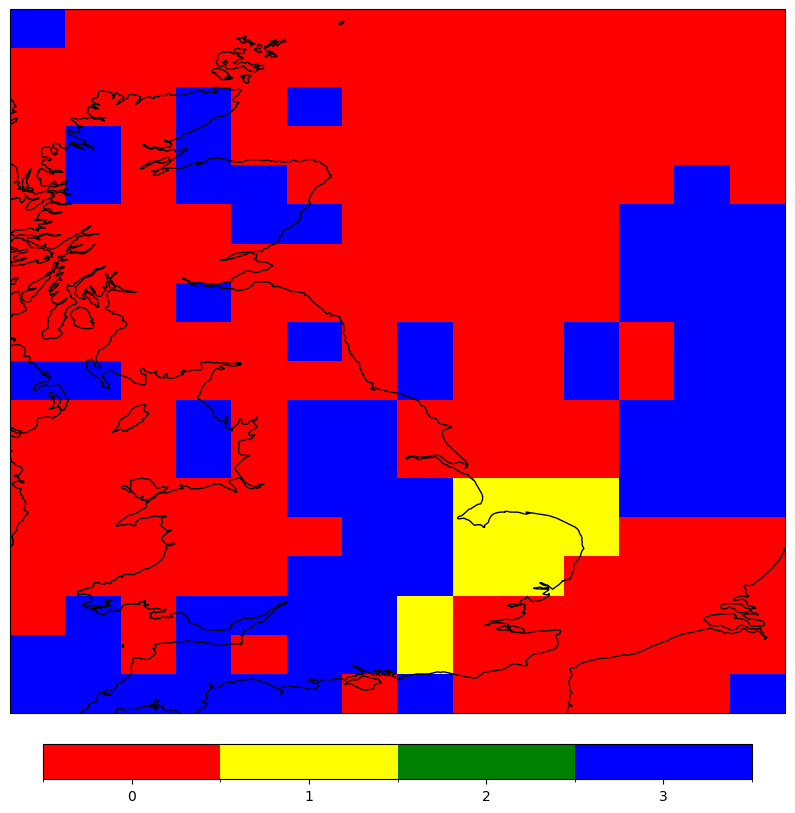

In [47]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.colors as mcolors

# # Example data
# results_array = np.random.randint(0, 3, (10, 10))  # Replace with your actual data
# model_lons = np.linspace(-180, 180, results_array.shape[1])
# model_lats = np.linspace(-90, 90, results_array.shape[0])

# Set up the figure
plt.figure(figsize=(10, 10))

# Set up the projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add the coastlines
ax.coastlines()

# Define the custom colormap
cmap = mcolors.ListedColormap(['red', 'yellow', 'green', 'blue'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

# Plot the data
im = plt.imshow(
    results_array,
    extent=[model_lons.min(), model_lons.max(), model_lats.min(), model_lats.max()],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    origin='upper',
    aspect='auto'
)

# Add the colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['0', '1', '2', '3'])

plt.show()